In [1]:
#Importing libraries needed for reading .nii files

import nibabel as nib
import numpy as np

from zipfile import ZipFile

import glob
import gzip
import shutil

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, activations
from tensorflow.keras import backend as K

import matplotlib.pyplot as plt

In [2]:
#Unzip zipped folder of original dataset

if False:
  with ZipFile('./drive/MyDrive/3D_images/hecktor_nii_cropped.zip', 'r') as f:
    f.extractall('./drive/MyDrive/3D_images')

In [3]:
#Preparing CT images and labels into desired folders
#This stage consists of unzipping and deviding inputs and targets to corresponding folders

if False:
  x = glob.glob('./drive/MyDrive/3D_images/hecktor_nii_cropped/*/', recursive = True)
  for item in x:
    y = glob.glob(item+'*', recursive = True)
    y.sort()
    s = y[0].split('/')[-1]
    with gzip.open(y[0], 'rb') as file_in:
      with open('./drive/MyDrive/3D_images/Input_images/'+s[:-3], 'wb') as file_out:
        shutil.copyfileobj(file_in, file_out)
    s = y[1].split('/')[-1]
    with gzip.open(y[1], 'rb') as file_in:
      with open('./drive/MyDrive/3D_images/Target_labels/'+s[:-3], 'wb') as file_out:
        shutil.copyfileobj(file_in, file_out)

In [4]:
x = glob.glob('./drive/MyDrive/3D_images/Input_images/*', recursive = True)
x.sort()
y = glob.glob('./drive/MyDrive/3D_images/Target_labels/*', recursive = True)
y.sort()

In [5]:
## Loading dataset to RAM and splitting to train/val/test sets
## by setting seed, we guarantee reproducability of splitting

seed = 42
indices = list(range(len(x)))
np.random.seed(seed=seed)
np.random.shuffle(indices)

train_indices = indices[60:]
val_indices = indices[30:60]
test_indices = indices[:30]

In [6]:
test_input = np.zeros(shape=(30,64,64,64), dtype='float64')
val_input = np.zeros(shape=(30,64,64,64), dtype='float64')
train_input = np.zeros(shape=(141,64,64,64), dtype='float64')

test_target = np.zeros(shape=(30,64,64,64), dtype='float64')
val_target = np.zeros(shape=(30,64,64,64), dtype='float64')
train_target = np.zeros(shape=(141,64,64,64), dtype='float64')

for i in range(30):
  test_input[i] = nib.load(x[test_indices[i]]).get_fdata()
  test_target[i] = nib.load(y[test_indices[i]]).get_fdata()

for i in range(30):
  val_input[i] = nib.load(x[val_indices[i]]).get_fdata()
  val_target[i] = nib.load(y[val_indices[i]]).get_fdata()

for i in range(141):
  train_input[i] = nib.load(x[train_indices[i]]).get_fdata()
  train_target[i] = nib.load(y[train_indices[i]]).get_fdata()

test_input = np.expand_dims(test_input, axis=-1)
val_input = np.expand_dims(val_input, axis=-1)
train_input = np.expand_dims(train_input, axis=-1)

test_target = np.expand_dims(test_target, axis=-1)
val_target = np.expand_dims(val_target, axis=-1)
train_target = np.expand_dims(train_target, axis=-1)

In [7]:
test_input /= 1000.
val_input /= 1000.
train_input /= 1000.

In [8]:
test_input = test_input.astype('float32')
val_input = val_input.astype('float32')
train_input = train_input.astype('float32')

In [9]:
def dice_coefficient(y_true, y_pred, smooth=1e-7):
    intersection = K.sum(K.abs(y_true * y_pred), axis=(1, 2, 3))
    union = K.sum(y_true, axis=(1, 2, 3)) + K.sum(y_pred, axis=(1, 2, 3))
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice

def bce_dice_loss(y_true, y_pred, epsilon=1e-7):
    #y_pred = K.clip(y_pred, epsilon, 1.0 - epsilon) # Clip to avoid numerical instability
    bce = K.mean(K.binary_crossentropy(y_true, y_pred), axis=(1, 2, 3))
    dice = 1 - dice_coefficient(y_true, y_pred)
    return 0.5*bce + 0.5*dice

In [10]:
def squeeze_excite_block(inputs, ratio=16):
  channels = inputs.shape[-1]  # Get the number of input channels
  se = layers.GlobalAveragePooling3D()(inputs)  # Apply global average pooling
  se = layers.Dense(channels // ratio, activation='relu')(se)  # Squeeze operation
  se = layers.Dense(channels, activation='sigmoid')(se)  # Excitation operation
  se = layers.Reshape((1, 1, channels))(se)  # Reshape to match input shape
  scaled_inputs = layers.Multiply()([inputs, se])  # Scale the input features
  return scaled_inputs

def conv_block(inputs , filters):
  x = layers.Conv3D(filters=filters, kernel_size=3, padding='same')(inputs)
  x = layers.BatchNormalization()(x)
  x = activations.elu(x)
  x = layers.Conv3D(filters=filters, kernel_size=3, padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = activations.elu(x)
  x = squeeze_excite_block(x)  # Apply the SE block
  return x

In [11]:
rate = 4 # with ratio=4, produced model will be identical to proposed moedel in the base paper. in here, we can decrease number of filters by using this variable

## Forward Model architecture

# Contracting Path (Encoder)
forward_inputs = layers.Input(shape=(64, 64, 64, 1))
conv1 = conv_block(forward_inputs, 8*rate)
pool1 = layers.MaxPooling3D(pool_size=(2, 2, 2))(conv1)

conv2 = conv_block(pool1, 16*rate)
pool2 = layers.MaxPooling3D(pool_size=(2, 2, 2))(conv2)

conv3 = conv_block(pool2, 32*rate)
pool3 = layers.MaxPooling3D(pool_size=(2, 2, 2))(conv3)

conv4 = conv_block(pool3, 64*rate)

# Bottom of the U-Net (Bottleneck)
conv5 = conv_block(conv4, 64*rate)
feedback = layers.Input(shape=(8, 8, 8, 64*rate))

decoder_forward = keras.Model(inputs=forward_inputs, outputs=[conv1, conv2, conv3, conv5])

conv5 = layers.concatenate([feedback, decoder_forward.outputs[3]], axis=4)  #base paper provides three metohods for feedback: concat, add, multiply
#conv5 = layers.Add()([feedback, decoder_forward.outputs[3]])
conv6 = conv_block(conv5, 128*rate)

# Expansive Path (Decoder)
up7 = layers.Conv3DTranspose(32*rate, 2, strides=(2, 2, 2), padding='same')(conv6)
up7 = layers.concatenate([up7, decoder_forward.outputs[2]], axis=4)
conv7 = conv_block(up7, 32*rate)

up8 = layers.Conv3DTranspose(16*rate, 2, strides=(2, 2, 2), padding='same')(conv7)
up8 = layers.concatenate([up8, decoder_forward.outputs[1]], axis=4)
conv8 = conv_block(up8, 16*rate)

up9 = layers.Conv3DTranspose(8*rate, 2, strides=(2, 2, 2), padding='same')(conv8)
up9 = layers.concatenate([up9, decoder_forward.outputs[0]], axis=4)
conv9 = conv_block(up9, 8*rate)

# Output layer
outputs = layers.Conv3D(1, 1, activation='sigmoid')(conv9)

forward_model = keras.Model(inputs=[forward_inputs,feedback], outputs=outputs)
forward_model.compile(optimizer='adam', loss=bce_dice_loss, metrics=[dice_coefficient])

In [12]:
## Feedback Model architecture

# Contracting Path (Encoder)
feedback_inputs = layers.Input(shape=(64, 64, 64, 1))
conv1 = layers.Conv3D(filters=8*rate, kernel_size=3, padding='same')(feedback_inputs)
conv1 = layers.BatchNormalization()(conv1)
conv1 = activations.elu(conv1)
pool1 = layers.MaxPooling3D(pool_size=(2, 2, 2))(conv1)

conv2 = layers.Conv3D(filters=16*rate, kernel_size=3, padding='same')(pool1)
conv2 = layers.BatchNormalization()(conv2)
conv2 = activations.elu(conv2)
pool2 = layers.MaxPooling3D(pool_size=(2, 2, 2))(conv2)

conv3 = layers.Conv3D(filters=32*rate, kernel_size=3, padding='same')(pool2)
conv3 = layers.BatchNormalization()(conv3)
conv3 = activations.elu(conv3)
pool3 = layers.MaxPooling3D(pool_size=(2, 2, 2))(conv3)

# Bottleneck
conv4 = layers.Conv3D(filters=64*rate, kernel_size=3, padding='same')(pool3)
conv4 = layers.BatchNormalization()(conv4)
conv4 = activations.elu(conv4)

decoder_feedback = keras.Model(inputs=feedback_inputs, outputs=conv4)

# Expansive Path (Decoder)
up5 = layers.UpSampling3D((2, 2, 2))(conv4)
conv5 = layers.Conv3D(filters=32*rate, kernel_size=3, padding='same')(up5)
conv5 = layers.BatchNormalization()(conv5)
conv5 = activations.elu(conv5)

up6 = layers.UpSampling3D((2, 2, 2))(conv5)
conv6 = layers.Conv3D(filters=16*rate, kernel_size=3, padding='same')(up6)
conv6 = layers.BatchNormalization()(conv6)
conv6 = activations.elu(conv6)

up7 = layers.UpSampling3D((2, 2, 2))(conv6)
conv7 = layers.Conv3D(filters=8*rate, kernel_size=3, padding='same')(up7)
conv7 = layers.BatchNormalization()(conv7)
conv7 = activations.elu(conv7)

# Output layer
outputs = layers.Conv3D(1, 1, activation='sigmoid')(conv7)

feedback_model = keras.Model(inputs=feedback_inputs, outputs=outputs)
feedback_model.compile(optimizer='adam', loss=bce_dice_loss, metrics=[dice_coefficient])

In [13]:
seed = 42
np.random.seed(seed=seed)
batch_size = 10
epoch = 50

training_loss = []
validation_loss = []
training_metric = []
validation_metric = []
testing_metric = []

for ite in range(epoch):
  print('Epoch', ite+1, ':')
  batch_indices = list(range(141))
  np.random.shuffle(batch_indices)

  for i in range(141//batch_size):
    # Phase 1
    forward_model.train_on_batch([train_input[batch_indices[i*batch_size:(i+1)*batch_size]], np.zeros(shape=(batch_size,8,8,8,64*rate), dtype='float64')], train_target[batch_indices[i*batch_size:(i+1)*batch_size]])

    # Phase 2
    y_hat = forward_model.predict([train_input[batch_indices[i*batch_size:(i+1)*batch_size]], np.zeros(shape=(batch_size,8,8,8,64*rate), dtype='float64')], verbose=0)
    feedback_model.train_on_batch(y_hat, train_target[batch_indices[i*batch_size:(i+1)*batch_size]])

    # Phase 3
    feedback = decoder_feedback.predict(y_hat, verbose=0)
    decoder_forward.trainable = False
    forward_model.train_on_batch([train_input[batch_indices[i*batch_size:(i+1)*batch_size]], feedback], train_target[batch_indices[i*batch_size:(i+1)*batch_size]])
    decoder_forward.trainable = True

  loss_train = 0
  metric_train = 0
  for i in range(141):
    y_hat = forward_model.predict([train_input[i:i+1], np.zeros(shape=(1,8,8,8,64*rate), dtype='float64')], verbose=0)
    feedback = decoder_feedback.predict(y_hat, verbose=0)
    p,q = forward_model.evaluate([train_input[i:i+1], feedback], train_target[i:i+1], verbose=0)
    loss_train += p
    metric_train += q
  print("Trainig Loss =", loss_train/141, "and Training metric =", metric_train/141)
  training_loss.append(loss_train/141)
  training_metric.append(metric_train/141)

  loss_val = 0
  metric_val = 0
  for i in range(30):
    y_hat = forward_model.predict([val_input[i:i+1], np.zeros(shape=(1,8,8,8,64*rate), dtype='float64')], verbose=0)
    feedback = decoder_feedback.predict(y_hat, verbose=0)
    p,q = forward_model.evaluate([val_input[i:i+1], feedback], val_target[i:i+1], verbose=0)
    loss_val += p
    metric_val += q
  print("Validation Loss =", loss_val/30, "and Validation metric =", metric_val/30)
  validation_loss.append(loss_val/30)
  validation_metric.append(metric_val/30)

  metric_test = 0
  for i in range(30):
    y_hat = forward_model.predict([test_input[i:i+1], np.zeros(shape=(1,8,8,8,64*rate), dtype='float64')], verbose=0)
    feedback = decoder_feedback.predict(y_hat, verbose=0)
    _,q = forward_model.evaluate([test_input[i:i+1], feedback], test_target[i:i+1], verbose=0)
    metric_test += q
  testing_metric.append(metric_test/30)
  print('--------------------')


Epoch 1 :
Trainig Loss = 1.2760463674017724 and Training metric = 0.0034619656920499555
Validation Loss = 1.2887765208880106 and Validation metric = 0.003213093290635935
--------------------
Epoch 2 :
Trainig Loss = 206.2621250093406 and Training metric = 0.0025965801889637945
Validation Loss = 170.68134853839874 and Validation metric = 0.002475002817948241
--------------------
Epoch 3 :
Trainig Loss = 1.2752167413420712 and Training metric = 0.004083506247802853
Validation Loss = 1.2679406801859539 and Validation metric = 0.0036460874505469965
--------------------
Epoch 4 :
Trainig Loss = 2.203544503408121 and Training metric = 0.0029554036522611185
Validation Loss = 1.7465345283349356 and Validation metric = 0.0031078418479541727
--------------------
Epoch 5 :
Trainig Loss = 140.6027272229499 and Training metric = 0.0026757371991774108
Validation Loss = 229.2391354640325 and Validation metric = 0.0024169425781061754
--------------------
Epoch 6 :
Trainig Loss = 0.7673731771766716 and

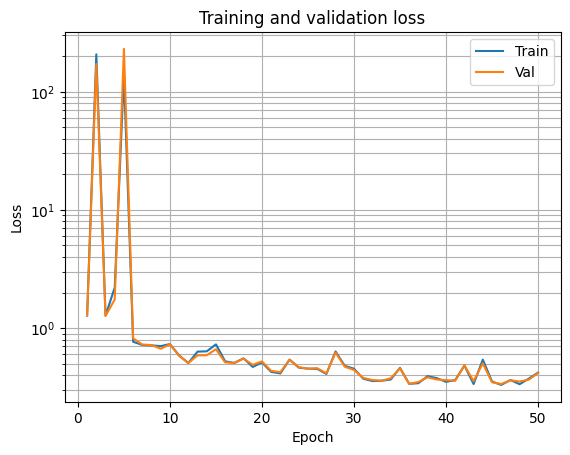

In [17]:
ite = np.array(list(range(epoch))) + 1
plt.semilogy(ite, training_loss, ite, validation_loss)
plt.grid(True, which="both")
plt.title('Training and validation loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(['Train', 'Val'])
plt.show()

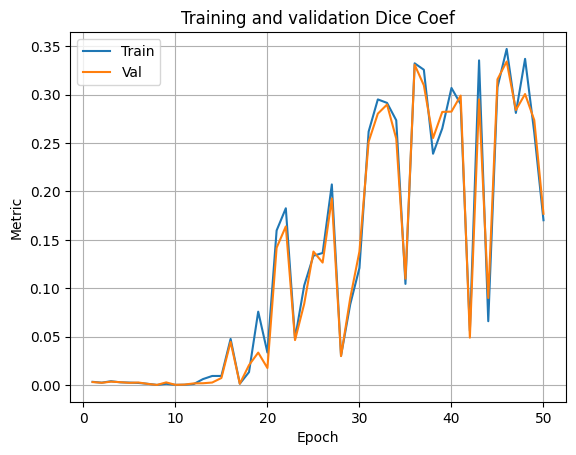

In [15]:
plt.grid(True, which="both")
plt.plot(ite, training_metric, ite, validation_metric)
plt.title('Training and validation Dice Coef')
plt.xlabel("Epoch")
plt.ylabel("Metric")
plt.legend(['Train', 'Val'])
plt.show()

In [16]:
best_epoch = np.argmax(validation_metric)
print('Best epoch is', best_epoch+1, 'and dice coefficient of test set at this epoch is', testing_metric[best_epoch])

Best epoch is 46 and dice coefficient of test set at this epoch is 0.29646627428520855
